<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/VAE/semi_supervised_VAE_08_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/wohlert/semi-supervised-pytorch/tree/master

Semi-Supervised Learning with Deep Generative Models

https://arxiv.org/abs/1406.5298


In [1]:
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
# sys.path.append("../../semi-supervised")

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from tqdm import tqdm

# from layers import GaussianSample, GaussianMerge, GumbelSoftmax
# from inference import log_gaussian, log_standard_gaussian

$\log var = \log \sigma ^2$

$\epsilon \sim \mathcal{N}(0, \boldsymbol{I}) $

https://github.com/wohlert/semi-supervised-pytorch/blob/master/semi-supervised/models/dgm.py


In [3]:
class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the reparametrization trick to
    draw a sample from a distribution parametrized by mu and logvar
    """
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar) # e^(1/2 * log𝜎2) = 𝜎 = std
        eps = torch.randn_like(std) # 𝜖∼N(0,𝐼)
        return mu + eps * std

class GaussianSample(Stochastic):
    """
    Layer that represents a sample from a Gaussian distribution
    """
    def __init__(self, in_dim, out_dim):
        super(GaussianSample, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        # print(f'in_dim:{in_dim}, out_dim:{out_dim}')
        self.mu_layer = nn.Linear(in_dim, out_dim)
        self.logvar_layer = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        mu = self.mu_layer(x)
        # https://pytorch.org/docs/stable/_images/Softplus.png
        logvar = F.softplus(self.logvar_layer(x))
        return self.reparametrize(mu, logvar), mu, logvar

In [4]:
class Encoder(nn.Module):
    def __init__(self, dims, sample_layer=GaussianSample):
        """
        Inference network:
        Attempts to infer the probability distribution p(z|x)
        from the data by fitting a variational distribution q_phi(z|x).
        (\mu, log \sigma ^2 ) =  q_phi(z|x)

        :param dims: dimensions of the networks
            given by the number of neurons on the form
            [input_dim, [hidden_dims], latent_dim]
        """
        super(Encoder, self).__init__()
        [x_dim, h_dim, z_dim] = dims
        neurons = [x_dim, *h_dim]
        linear_layers = [nn.Linear(
            neurons[i-1], neurons[i]) for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.sample = sample_layer(h_dim[-1], z_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        return self.sample(x)
        # GaussianSample: return self.reparametrize(mu, logvar), mu, logvar

class Decoder(nn.Module):
    def __init__(self, dims):
        """
        Generative network:
        Generate samples from the original distribution p(x)
        by transforming a latent representation p_\theta(x|z)

        :param dims: dimensions of the networks
            given by the number of neurons on the form
            [latent_dim, [hidden_dims], input_dim]
        """
        super(Decoder, self).__init__()
        [z_dim, h_dim, x_dim] = dims
        neurons = [z_dim, *h_dim]
        linear_layers = [nn.Linear(
            neurons[i-1], neurons[i]) for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.reconstruction = nn.Linear(h_dim[-1], x_dim)
        self.output_activation = nn.Sigmoid()

    def forward(self, z):
        for layer in self.hidden:
            z = F.relu(layer(z))
            z = self.reconstruction(z)
            return self.output_activation(z)

In [5]:
class VAE(nn.Module):
    def __init__(self, dims):
        super(VAE, self).__init__()
        """
        :param dims: [x_dim, z_dim, h_dim]
        """
        [x_dim, z_dim, h_dim] = dims
        # print(f"x_dim: {x_dim}, z_dim: {z_dim}, h_dim: {h_dim}")
        self.z_dim = z_dim
        self.flow = None
        self.encoder = Encoder([x_dim, h_dim, z_dim])
        self.decoder = Decoder([z_dim, list(reversed(h_dim)), x_dim])
        # self.kl_divergence = 0

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def add_flow(self, flow):
        self.flow = flow

    def forward(self, x, y=None):
        """
        :param x: input data
        :return reconstructed input
        """
        z, z_mu, z_logvar = self.encoder(x)
        return self.decoder(z)
    def sample(self, z):
        return self.decoder(z)

In [6]:
class Classifier(nn.Module):
    def __init__(self, dims):
        """
        Single hidden layer classifier with softmax output
        """
        super(Classifier, self).__init__()
        [x_dim, h_dim, y_dim] = dims
        self.dense = nn.Linear(x_dim, h_dim)
        self.logits = nn.Linear(h_dim, y_dim)
    def forward(self, x):
        x = F.relu(self.dense(x))
        x = F.softmax(self.logits(x), dim=-1)
        return x

class DeepGenerativeModel(VAE):
    """
    M2 code replication
    """
    def __init__(self, dims):
        [x_dim, self.y_dim, z_dim, h_dim] = dims
        # print(x_dim, self.y_dim, z_dim, h_dim)
        super(DeepGenerativeModel, self).__init__([x_dim, z_dim, h_dim])
        self.encoder = Encoder([x_dim+self.y_dim, h_dim, z_dim])
        self.decoder = Decoder([z_dim+self.y_dim, list(reversed(h_dim)), x_dim])

        # Only used one layer h_dim[0] since classifier is defined this way
        self.classifier = Classifier([x_dim, h_dim[0], self.y_dim])

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal(m.weight.data)
                if m.bias is not None: m.bias.data.zero_()

    def forward(self, x, y):
        z, z_mu, z_logvar = self.encoder(torch.cat([x, y], dim=1))
        x = self.decoder(torch.cat([z,y], dim=1))
        return x

    def set_classifier(self, classifier):
        self.classifier = classifier

    def classify(self, x): return self.classifier(x)

    def sample(self, z, y):
        """
        Samples from the decoder to generate x
        :param z: latent normal variable
        :param y: label (one-hot encoded)
        :return: x
        """
        y = y.float()
        x = self.decoder(torch.cat([z,y], dim=1))
        return x

In [7]:
class StackedDGM(DeepGenerativeModel):
    """
    M1 + M2 from paper 'Semi-Supervised Learning with Deep Generative Models'
    (Kingma 2014) in PyTorch.
    """
    def __init__(self, dims, features):
        """
        :param dims: dimensions of x, y, z and hidden layers
        :param features: M1 model of VAE
        """
        [x_dim, y_dim, z_dim, h_dim] = dims
        super(StackedDGM, self).__init__([features.z_dim, y_dim, z_dim, h_dim])
        in_dim = self.decoder.reconstruction.in_features
        self.decoder.reconstruction = nn.Linear(in_dim, x_dim)

        self.features = features
        self.features.train(False) # Do not train features p_\theta(x)

        for param in self.features.parameters(): param.requires_grad=False

    def forward(self, x, y):
        z_sample, _, _ = self.features.encoder(x)
        return super(StackedDGM, self).forward(z_sample, y)

    def classify(self, x):
        _, z_mu, _ = self.features.encoder(x)
        logits = self.classifier(x)
        return logits

In [8]:
y_dim = 10
z_dim = 20
h_dim = [256, 128]
model = DeepGenerativeModel([784, y_dim, z_dim, h_dim])
model

<ipython-input-5-9ae8a1dbfa8a>:17: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)
<ipython-input-6-107defe77478>:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


DeepGenerativeModel(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=794, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (sample): GaussianSample(
      (mu_layer): Linear(in_features=128, out_features=20, bias=True)
      (logvar_layer): Linear(in_features=128, out_features=20, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=30, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
    (reconstruction): Linear(in_features=256, out_features=784, bias=True)
    (output_activation): Sigmoid()
  )
  (classifier): Classifier(
    (dense): Linear(in_features=784, out_features=256, bias=True)
    (logits): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [35]:
import torch
import numpy as np
import sys
from urllib import request
from torch.utils.data import Dataset
def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

cuda = torch.cuda.is_available()
import torchvision.transforms as transforms
flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

def get_mnist(location='./', batch_size=64, labels_per_class=100):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms
    n_labels=10

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli,
                        target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli,
                        target_transform=onehot(n_labels))
    def get_sampler(labels, n=None):
        (indices, ) = np.where(reduce(__or__,
         [labels==i for i in np.arange(n_labels)]))
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i,
                              indices))[:n] for i in range(n_labels)])
        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler
    labelled = torch.utils.data.DataLoader(
        mnist_train, batch_size=batch_size, num_workers=2, pin_memory=cuda,
        sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(
        mnist_train, batch_size=batch_size, num_workers=2, pin_memory=cuda,
        sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(
        mnist_valid, batch_size=batch_size, num_workers=2, pin_memory=cuda,
        sampler=get_sampler(mnist_valid.test_labels.numpy()))
    return labelled, unlabelled, validation


In [10]:
labelled, unlabelled, validation = get_mnist(location="./", batch_size=64, labels_per_class=10)

100%|██████████| 9912422/9912422 [00:00<00:00, 505461335.69it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24878967.72it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 123093610.22it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3791904.61it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [22]:
alpha = 0.1 * len(unlabelled) / len(labelled)
len(labelled), len(unlabelled), len(validation), alpha

(2, 938, 157, 46.900000000000006)

In [23]:
!git clone https://github.com/wohlert/semi-supervised-pytorch.git


Cloning into 'semi-supervised-pytorch'...
remote: Enumerating objects: 326, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 326 (delta 36), reused 35 (delta 35), pack-reused 281
Receiving objects: 100% (326/326), 12.76 MiB | 16.96 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [24]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")

In [28]:
cd /content/semi-supervised-pytorch/semi-supervised

/content/semi-supervised-pytorch/semi-supervised


In [12]:
from torchvision.datasets import MNIST
mnist_train = MNIST('./', train=True, download=True,
                        transform=flatten_bernoulli,
                        target_transform=onehot(10))

In [29]:
from models import DeepGenerativeModel, StackedDeepGenerativeModel

y_dim = 10
z_dim = 32
h_dim = [256, 128]

model = DeepGenerativeModel([784, y_dim, z_dim, h_dim])
model

/content/semi-supervised-pytorch/semi-supervised/models/vae.py:114: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)
/content/semi-supervised-pytorch/semi-supervised/models/dgm.py:50: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


DeepGenerativeModel(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=794, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=32, bias=True)
      (log_var): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=42, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
    (reconstruction): Linear(in_features=256, out_features=784, bias=True)
    (output_activation): Sigmoid()
  )
  (classifier): Classifier(
    (dense): Linear(in_features=784, out_features=256, bias=True)
    (logits): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [30]:
print(model.encoder.hidden[0])
print(model.decoder.hidden[0])

Linear(in_features=794, out_features=256, bias=True)
Linear(in_features=42, out_features=128, bias=True)


In [36]:
# from datautils import get_mnist

# Only use 10 labelled examples per class
# The rest of the data is unlabelled.
labelled, unlabelled, validation = get_mnist(location="./", batch_size=64, labels_per_class=10)
alpha = 0.1 * len(unlabelled) / len(labelled)

def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [37]:
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler

# You can use importance weighted samples [Burda, 2015] to get a better estimate
# on the log-likelihood.
sampler = ImportanceWeightedSampler(mc=1, iw=1)

if cuda: model = model.cuda()
elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)

In [181]:
from torch.autograd import Variable

for epoch in range(10):
    model.train()
    total_loss, accuracy = (0, 0)
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        # Wrap in variables
        x, y, u = Variable(x), Variable(y), Variable(u)
        print('x: ', x.shape)
        if cuda:
            # They need to be on the same device and be synchronized.
            x, y = x.cuda(device=0), y.cuda(device=0)
            u = u.cuda(device=0)

        L = -elbo(x, y)
        U = -elbo(u)

        # Add auxiliary classification loss q(y|x)
        logits = model.classify(x)

        # Regular cross entropy
        classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

        J_alpha = L - alpha * classication_loss + U

        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print(J_alpha.data)
        total_loss += J_alpha.item()
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

    if epoch % 1 == 0:
        model.eval()
        m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

        total_loss, accuracy = (0, 0)
        for x, y in validation:
            x, y = Variable(x), Variable(y)

            if cuda:
                x, y = x.cuda(device=0), y.cuda(device=0)

            L = -elbo(x, y)
            U = -elbo(x)

            logits = model.classify(x)
            classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L + alpha * classication_loss + U

            total_loss += J_alpha.data.item()

            _, pred_idx = torch.max(logits, 1)
            _, lab_idx = torch.max(y, 1)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        m = len(validation)
        print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))


x:  torch.Size([64, 784])


AttributeError: ignored

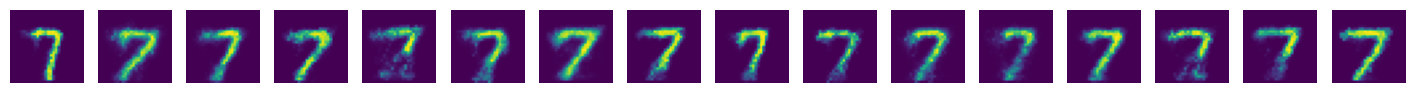

In [50]:
model.eval()

z = Variable(torch.randn(16, 32))

# Generate a batch of 7s
y = Variable(onehot(10)(7).repeat(16, 1))

x_mu = model.sample(z.cuda(), y.cuda()).cpu()

f, axarr = plt.subplots(1, 16, figsize=(18, 12))

samples = x_mu.data.view(-1, 28, 28).numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i])
    ax.axis("off")

In [54]:
from models import VariationalAutoencoder, StackedDeepGenerativeModel
import copy
# features = VariationalAutoencoder([784, z_dim, h_dim]).cuda()
features = copy.deepcopy(model)


RuntimeError: ignored

In [47]:
model = StackedDeepGenerativeModel([784, y_dim, z_dim, h_dim], features)

(device(type='cpu'), device(type='cpu'))

In [63]:
data_jak1_path = '/content/drive/MyDrive/JAK_ML/data/JAK1_final.csv'
import pandas as pd
data_jak1 = pd.read_csv(data_jak1_path)
data_jak1.head()

#
# new_d.category()

,Unnamed: 0,Smiles,Activity
0,0,COCCOC1CCCN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3ncnc...,1
1,1,CC(C)COC1CCCN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3nc...,1
2,2,C[C@H]1CN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3ncnc4[...,1
3,3,C[C@@H]1C[C@@H](CS(=O)(=O)N2CC[C@H](CO)C2)CC[C...,1
4,4,CN(c1ncnc2[nH]ccc12)[C@H]1CC[C@H](CS(=O)(=O)N2...,1


In [74]:
! pip install rdkit --quiet
from rdkit.Chem import MACCSkeys
from rdkit import Chem
import rdkit
def smile_list_to_MACCS(smi_list):
    MACCS_list = []
    for smi in smi_list:
        mol = Chem.MolFromSmiles(smi)
        maccs = list(float(i) for i in MACCSkeys.GenMACCSKeys(mol).ToBitString())
        MACCS_list.append(maccs)
    return MACCS_list

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 61.4 MB/s eta 0:00:00


In [75]:
df = pd.DataFrame()
header = ['bit' + str(i) for i in range(167)]

df = pd.DataFrame(smile_list_to_MACCS(data_jak1['Smiles']), columns=header)

In [77]:
df['Activity'] = data_jak1['Activity']

In [198]:
class Binary_Classifier(nn.Module):
    def __init__(self, dims):
        """
        predicts y ~ p(y|x)
        :param dims: [x_dim, h_dims, y_dim],
            :x_dim: input dimension
            :y_dim: output dimension
            :h_dims: hidden layers dimensions
        """
        # del x_dim
        # del h_dims
        # del y_dim
        super(Binary_Classifier, self).__init__()
        [x_dim, h_dims, y_dim] = dims

        neurons = [x_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.logits = nn.Linear(h_dims[-1], y_dim)

    def forward(self, x):
        for layer in self.hidden:
            # print('now x shape: ', x.shape)
            # print(layer)
            x = layer(x)
            x = F.relu(x)
            # x = F.relu(layer(x))
        px_y = F.softmax(self.logits(x), dim=-1)
        return px_y


In [138]:
from sklearn.model_selection import train_test_split, cross_val_score
train, test = train_test_split(df, test_size=0.2)
# X = df[header]
# y = df['Activity']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
#                                                     random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [107]:
train.shape

(5898, 168)

In [199]:
from torch.utils.data import DataLoader, Dataset
class JAK_loader(Dataset):
    def __init__(self, df):
        super(JAK_loader, self).__init__()
        self.len = len(df)
        self.df = df

    def __len__(self): return self.len

    def __getitem__(self, idx):
        fp = self.df[header].iloc[idx]
        fp = torch.tensor([float(i) for i in fp])
        label = self.df['Activity'].iloc[idx]
        label = onehot(2)(label)
        return fp, label

In [124]:
# np.random.choice(4, replace = True, size = 6)

In [232]:
import torch.optim as optim
optimizer = optim.AdamW(params=model.parameters(), lr=1e-2, weight_decay=1e-2)

params_jak = {'batch_size': 64, 'shuffle': True,
              'drop_last': False, 'num_workers': 0}
train_loader = DataLoader(JAK_loader(train.reset_index(drop=True)),
                          **params_jak)
test_loader = DataLoader(JAK_loader(test.reset_index(drop=True)),
                          **params_jak)


In [233]:
x_dim = 167
y_dim = 2
h_dims = [128, 64, 10]
model = Binary_Classifier([x_dim, h_dims, y_dim])

In [234]:
model
loss_function = nn.MSELoss()
# fp.shape

In [247]:
optimizer = optim.AdamW(params=model.parameters(), lr=1e-2)
acc_vals = {}
for epoch in range(100):
    print("Epoch: {}".format(epoch))
    model.train()
    total_loss, accuracy = (0, 0)

    for idx, (fp, label) in tqdm(enumerate(train_loader),
                                 total=len(train_loader)):
        optimizer.zero_grad()
        fp, label = Variable(fp), Variable(label)
        if cuda:
            model = model.cuda()
            fp, label = fp.cuda(), label.cuda()

        label_hat = model(fp)
        loss = loss_function(label_hat, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        accuracy += torch.mean((
        torch.max(label_hat, 1)[1].data == torch.max(label, 1)[1].data).float())

    print("[Train]\t\t Total_loss: {:.2f}, accuracy: {:.2f}".format(
        total_loss / len(train_loader), accuracy / len(train_loader)))

    if epoch % 1 == 0:
        model.eval()
        total_loss_val, accuracy_val = (0, 0)
        for idx, (fp, label) in tqdm(enumerate(test_loader),
                                     total=len(test_loader)):
            fp, label = Variable(fp), Variable(label)
            if cuda: fp, label = fp.cuda(), label.cuda()
            label_hat = model(fp)
            loss = loss_function(label_hat, label)
            total_loss_val += loss.data.item()
            accuracy_val += torch.mean((
            torch.max(label_hat, 1)[1].data == torch.max(label, 1)[1].data).float())

        # m = len(test_loader)
        print("[Validation]\t total_loss: {:.2f}, accuracy: {:.2f}".format(
        total_loss_val / len(test_loader), accuracy_val / len(test_loader)))
        acc_vals[epoch] = accuracy_val / len(test_loader)


Epoch: 0


100%|██████████| 93/93 [00:42<00:00,  2.18it/s]


[Train]		 Total_loss: 0.08, accuracy: 0.89


100%|██████████| 24/24 [00:03<00:00,  6.32it/s]


[Validation]	 total_loss: 0.07, accuracy: 0.89
Epoch: 1


100%|██████████| 93/93 [00:42<00:00,  2.21it/s]


[Train]		 Total_loss: 0.07, accuracy: 0.91


100%|██████████| 24/24 [00:03<00:00,  6.26it/s]


[Validation]	 total_loss: 0.08, accuracy: 0.88
Epoch: 2


100%|██████████| 93/93 [00:42<00:00,  2.21it/s]


[Train]		 Total_loss: 0.06, accuracy: 0.91


100%|██████████| 24/24 [00:03<00:00,  6.32it/s]


[Validation]	 total_loss: 0.07, accuracy: 0.92
Epoch: 3


100%|██████████| 93/93 [00:42<00:00,  2.21it/s]


[Train]		 Total_loss: 0.06, accuracy: 0.92


100%|██████████| 24/24 [00:03<00:00,  6.35it/s]


[Validation]	 total_loss: 0.06, accuracy: 0.92
Epoch: 4


100%|██████████| 93/93 [00:42<00:00,  2.20it/s]


[Train]		 Total_loss: 0.06, accuracy: 0.92


100%|██████████| 24/24 [00:03<00:00,  6.23it/s]


[Validation]	 total_loss: 0.06, accuracy: 0.93
Epoch: 5


100%|██████████| 93/93 [00:42<00:00,  2.18it/s]


[Train]		 Total_loss: 0.05, accuracy: 0.93


100%|██████████| 24/24 [00:03<00:00,  6.29it/s]


[Validation]	 total_loss: 0.07, accuracy: 0.92
Epoch: 6


100%|██████████| 93/93 [00:42<00:00,  2.18it/s]


[Train]		 Total_loss: 0.05, accuracy: 0.93


100%|██████████| 24/24 [00:03<00:00,  6.25it/s]


[Validation]	 total_loss: 0.06, accuracy: 0.93
Epoch: 7


100%|██████████| 93/93 [00:42<00:00,  2.18it/s]


[Train]		 Total_loss: 0.05, accuracy: 0.94


100%|██████████| 24/24 [00:04<00:00,  5.98it/s]


[Validation]	 total_loss: 0.06, accuracy: 0.93
Epoch: 8


100%|██████████| 93/93 [00:42<00:00,  2.20it/s]


[Train]		 Total_loss: 0.05, accuracy: 0.93


100%|██████████| 24/24 [00:03<00:00,  6.31it/s]


[Validation]	 total_loss: 0.07, accuracy: 0.92
Epoch: 9


100%|██████████| 93/93 [00:42<00:00,  2.21it/s]


[Train]		 Total_loss: 0.04, accuracy: 0.94


100%|██████████| 24/24 [00:03<00:00,  6.29it/s]


[Validation]	 total_loss: 0.07, accuracy: 0.91
Epoch: 10


  9%|▊         | 8/93 [00:03<00:39,  2.13it/s]


KeyboardInterrupt: ignored

In [285]:
import pandas as pd
from os import walk
import os
from collections import OrderedDict
import numpy as np
import math
import json
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from rdkit.Chem import MACCSkeys
from rdkit import Chem
import torch
import pickle
from sklearn.model_selection import train_test_split

In [249]:
model_path = '/content/drive/MyDrive/A_MODEL/'

In [250]:
torch.save(model.state_dict(), model_path+'binary_classifier_jak1.pt')

In [177]:
linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
hidden = nn.ModuleList(linear_layers)
hidden

ModuleList(
  (0): Linear(in_features=167, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [264]:
new_model = Binary_Classifier([x_dim, h_dims, y_dim])
device = torch.device('cuda')
new_model.load_state_dict(
    torch.load(model_path + 'binary_classifier_jak1.pt', map_location=device))

<All keys matched successfully>

In [277]:
p = new_model(torch.Tensor([float(i) for i in df[header].iloc[0]]))
pred, prob = torch.argmax(p), torch.max(p)
print(f'pred: {pred}, prob:{prob:.2f}')

pred:1, prob:0.95


In [274]:
torch.argmax(p).item(), torch.max(p).item()

(1, 0.9516749382019043)

In [184]:
lin = nn.Linear(167, 10)
inp = torch.randn(16, 167)
out = lin(inp)

In [185]:
type(inp)

torch.Tensor

In [186]:
type(fp)

torch.Tensor

In [187]:
fp.shape, inp.shape

(torch.Size([16, 167]), torch.Size([16, 167]))

In [286]:
def get_preds(threshold, probabilities):
    try:
        if probabilities.shape[1] == 2:
            probabilities = probabilities[:, 1]
    except:
        pass
    return [1 if prob > threshold else 0 for prob in probabilities]

def evaluate_model(TP, FP, TN, FN):

    ACCURACY = (TP + TN) / (TP+FP+TN+FN)
    SE = TP/(TP+FN)
    recall = SE
    SP = TN/(TN+FP)
    weighted_accuracy = (SE + SP) / 2

    precision = TP / (TP + FP)
    SP = TN/(TN+FP)
    F1 = 2 * precision * recall /(precision + recall)

    temp = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
    if temp != 0:
        MCC = (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
    else:
        print('equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))')
        print('TP, FP, TN, FN', TP, FP, TN, FN)
        print('temp=0')
        MCC = 'N/A'

    return ACCURACY,SE, SP, weighted_accuracy, precision, F1, MCC


def evaluate(y_real, y_hat, y_prob):
    TN, FP, FN, TP = confusion_matrix(y_real, y_hat).ravel()
    ACCURACY,SE, SP, weighted_accuracy, precision, F1, MCC  = evaluate_model(TP, FP, TN, FN)
    try:
        if y_prob.shape[1] == 2:
            proba = y_prob[:, 1]
        else:
            proba = y_prob
    except:
        proba = y_prob
    AP = average_precision_score(y_real, proba)
    AUC = roc_auc_score(y_real, proba)
    print('Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP')
    if MCC != 'N/A':
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC),
      "&%8.3f" % (MCC), "&%8.3f" % (AP))
    else:
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC), "& ",
        MCC, "&%8.3f" % (AP))


In [319]:
BARICITINIB = 'CCS(=O)(=O)N1CC(C1)(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3'

drug = 'CC1=CN=C(N=C1NC2=CC(=CC=C2)S(=O)(=O)NC(C)(C)C)NC3=CC=C(C=C3)OCCN4CCCC4'
drug = data_jak1.iloc[0]['Smiles']
mol = Chem.MolFromSmiles(drug)
maccs = list(float(i) for i in MACCSkeys.GenMACCSKeys(mol).ToBitString())
p = new_model(torch.Tensor(maccs))
pred = torch.argmax(p)
prob = p[1]
# pred, prob = torch.argmax(p), torch.max(p)
print(f'pred: {pred}, prob:{prob:.2f}')

pred: 1, prob:0.95


In [318]:
data_jak1.iloc[0]['Smiles']

'COCCOC1CCCN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3ncnc4[nH]ccc34)CC2)C1'

In [309]:
preds, probs = [], []
for loc in range(len(data_jak1)):
    smi = data_jak1['Smiles'].iloc[loc]
    # act = data_jak1['Activity'].iloc[loc]
    mol = Chem.MolFromSmiles(smi)
    maccs = list(float(i) for i in MACCSkeys.GenMACCSKeys(mol).ToBitString())
    p = new_model(torch.Tensor(maccs))
    pred, prob = torch.argmax(p).item(), p[1].item()
    preds.append(pred)
    probs.append(prob)
    # print(smi)

In [310]:
evaluate(data_jak1['Activity'], preds, probs)

Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.939  &  0.902  &          0.948  &     0.973  &0.831  &0.960 &0.979 &   0.829 &   0.993


In [320]:
! pip install selfies --quiet

In [334]:
import selfies
# valid_num = 0
sfs = []
for loc in range(len(data_jak1)):
    smi = data_jak1['Smiles'].iloc[loc]
    try:
        sf = selfies.encoder(smi)
        smi = selfies.decoder(sf)
        sfs.append(sf)
        # valid_num+=1
    except selfies.EncoderError: pass
    except selfies.DecoderError: pass
print(len(sfs), len(data_jak1))

7373 7373


In [ ]:
sfs

In [335]:
import selfies
alphabet = selfies.get_alphabet_from_selfies(sfs)
alphabet.add("[nop]")

In [336]:
max_len = max(selfies.len_selfies(s) for s in sfs)
symbol_to_idx = {s:i for i, s in enumerate(alphabet)}
label, onehot = selfies.selfies_to_encoding(
    selfies=sfs[0], vocab_stoi=symbol_to_idx, pad_to_len=max_len, enc_type="both"
)

In [344]:
model_selfies = Binary_Classifier([max_len, h_dims, y_dim])

In [339]:
optimizer = optim.AdamW(params=model.parameters(), lr=1e-2)
acc_vals = {}
for epoch in range(100):
    print("Epoch: {}".format(epoch))
    model.train()
    total_loss, accuracy = (0, 0)

    for idx, (fp, label) in tqdm(enumerate(train_loader),
                                 total=len(train_loader)):
        optimizer.zero_grad()
        fp, label = Variable(fp), Variable(label)
        if cuda:
            model = model.cuda()
            fp, label = fp.cuda(), label.cuda()

        label_hat = model(fp)
        loss = loss_function(label_hat, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        accuracy += torch.mean((
        torch.max(label_hat, 1)[1].data == torch.max(label, 1)[1].data).float())

    print("[Train]\t\t Total_loss: {:.2f}, accuracy: {:.2f}".format(
        total_loss / len(train_loader), accuracy / len(train_loader)))

    if epoch % 1 == 0:
        model.eval()
        total_loss_val, accuracy_val = (0, 0)
        for idx, (fp, label) in tqdm(enumerate(test_loader),
                                     total=len(test_loader)):
            fp, label = Variable(fp), Variable(label)
            if cuda: fp, label = fp.cuda(), label.cuda()
            label_hat = model(fp)
            loss = loss_function(label_hat, label)
            total_loss_val += loss.data.item()
            accuracy_val += torch.mean((
            torch.max(label_hat, 1)[1].data == torch.max(label, 1)[1].data).float())

        # m = len(test_loader)
        print("[Validation]\t total_loss: {:.2f}, accuracy: {:.2f}".format(
        total_loss_val / len(test_loader), accuracy_val / len(test_loader)))
        acc_vals[epoch] = accuracy_val / len(test_loader)


'[C][O][C][C][O][C][C][C][C][N][Branch2][Ring2][Branch1][S][=Branch1][C][=O][=Branch1][C][=O][C][C@H1][C][C][C@H1][Branch2][Ring1][C][N][Branch1][C][C][C][=N][C][=N][C][NH1][C][=C][C][Ring1][=Branch2][=Ring1][Branch1][C][C][Ring1][P][C][Ring2][Ring1][O]'

In [340]:
selfies.decoder(sfs[0])

'COCCOC1CCCN(S(=O)(=O)C[C@H1]2CC[C@H1](N(C)C3=NC=NC=4[NH1]C=CC3=4)CC2)C1'